In [66]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

## Question 1

In [67]:
#func to define params for problem 1
def get_airline_params():
    return {
        'coach_seats': 100,
        'first_class_seats': 20,
        'days_until_takeoff': 365,
        'coach_prices': [300, 350],
        'first_class_prices': [425, 500],
        'coach_sale_prob': {300: 0.65, 350: 0.30},
        'coach_sale_prob_fc_sold_out': {300: 0.68, 350: 0.33},
        'first_class_sale_prob': {425: 0.08, 500: 0.04},
        'coach_show_prob': 0.95,
        'first_class_show_prob': 0.97,
        'cost_bump_to_first_class': 50,
        'cost_bump_off_plane': 425,
        'annual_discount_rate': 0.17
    }


In [68]:
#func to define discount factor
def get_discount_factor(annual_rate):
    return 1 / (1 + annual_rate / 365)

In [69]:
#func to calculate terminal condition
def calculate_terminal_costs(V, max_coach_tickets, first_class_seats, coach_show_prob, 
                             first_class_show_prob, coach_seats, cost_bump_to_fc, cost_bump_off):
    for coach_sold in range(max_coach_tickets + 1): #iterate over every possible combination of how many tickets were sold in coach
        for fc_sold in range(first_class_seats + 1): #iterate over every possible combination of how many tickets were sold in first class
            cost = 0 #initialize cost
            for coach_show in range(coach_sold + 1): #for all possible numbers of coach passengers who might show up
                c_prob = binom.pmf(coach_show, coach_sold, coach_show_prob) #simulate probability of this scenario using binomial dist
                for fc_show in range(fc_sold + 1): #for all possible numbers of first class passengers who might show up
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob) #simulate probability of this scenario using binomial dist
                    scenario_prob = c_prob * fc_prob #calculate probability of this exact scenario - indeepent events so multiply
                    if coach_show > coach_seats: #if more passengers show up than there are coach seats available
                        bumped = coach_show - coach_seats #calculate number of passengers to be bumped - people who cant be seated in coach
                        available_fc = max(0, first_class_seats - fc_show) #calculate number of first class seats available - bumped will be put there first
                        bumped_to_fc = min(bumped, available_fc) #the rest will be bumped off the plane
                        bumped_off = bumped - bumped_to_fc #calculate number of passengers to be bumped off plane
                        cost += scenario_prob * (bumped_to_fc * cost_bump_to_fc + bumped_off * cost_bump_off) #compute the expected cost of this show-up scenario (weighted by its probability)
            V[coach_sold, fc_sold, -1] = -cost #store negative cost as terminal value
    return V #return the updated value matrix with all terminal day costs filled in.

In [70]:
# finds the optimal ticket pricing policy for each day leading up to a flight in order to maximize the airline’s expected discounted profit.
def run_dp_single(ob_level, params):
    # unpack the parameters from param dictionary
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    max_coach_tickets = coach_seats + ob_level
    days = params['days_until_takeoff']
    discount = get_discount_factor(params['annual_discount_rate'])

    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']

    # initialize value matrix to store the best expected profit for each possible state
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days + 1))
    # initialize policy matrix U to store the optimal ticket pricing decision at each state
    U = np.zeros_like(V, dtype=int)

    # fill in V with the negative expected overbooking costs on the day of the flight.
    V = calculate_terminal_costs(V, max_coach_tickets, first_class_seats,
                                 params['coach_show_prob'], params['first_class_show_prob'],
                                 coach_seats, params['cost_bump_to_first_class'], params['cost_bump_off_plane'])

    for day in range(days - 1, -1, -1): #work backward from day 364 to day 0.
        for coach_sold in range(max_coach_tickets + 1): #iterate over every possible combination of how many tickets were sold in coach
            for fc_sold in range(first_class_seats + 1): # iterate over every possible combination of how many tickets were sold in first class
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats: #skip if more tickets were sold than available - not possible
                    continue

                coach_available = coach_sold < max_coach_tickets #check if there are any coach seats available
                fc_available = fc_sold < first_class_seats #check if there are any first class seats available

                if not coach_available and not fc_available: #If both cabins are full, do nothing but discount the future value.
                    V[coach_sold, fc_sold, day] = discount * V[coach_sold, fc_sold, day + 1] 
                    continue

                
                if fc_sold == first_class_seats: #if first class is sold out
                    best_value = float('-inf') #initialize best value to negative infinity, asssuming the worst until we find sometjing
                    best_action = -1 #initialize best action to -1 whic is invalid 
                    for c_idx, coach_price in enumerate(coach_prices): #iterate over all possible coach prices
                        action = c_idx * 2 + 1  # either 1 or 3 - force the FC price to be the high one (index 1, or $500) — even though it won't be used — so the logic still holds and the action index remains valid
                        expected_revenue = 0 #initialize expected revenue from this action to 0

                        if coach_available: #if we have the capacity to sell coach tickets
                            c_prob = coach_sale_prob_fc_sold_out[coach_price] # get the boosted sale probability for coach (because FC is sold out)
                            expected_revenue += c_prob * coach_price #calculate expected revenue from selling coach tickets; (probability a ticket sells) × (price of that ticket)

                            prob_no_sale = 1 - c_prob #calculate probability of not selling a ticket
                            expected_future_value = (prob_no_sale * V[coach_sold, fc_sold, day + 1] +
                                                     c_prob * V[coach_sold + 1, fc_sold, day + 1]) #calculate expected future value based on whether a ticket is sold or not
                        else: #if we don't have the capacity to sell coach tickets
                            expected_future_value = V[coach_sold, fc_sold, day + 1] #expected future value is the same as the value for the next day - no revenue now

                        current_value = expected_revenue + discount * expected_future_value #combine expected immediate rewvenue from a coach sale with Discounted expected future value (from the next day’s state)
                        if current_value > best_value: # if this pricing strategy is better than what we’ve seen so far.
                            best_value = current_value #update the best value
                            best_action = action #  update the best action

                    V[coach_sold, fc_sold, day] = best_value #The best possible expected profit at this state 
                    U[coach_sold, fc_sold, day] = best_action #The action (pricing strategy) that gives us that best value

                else: #if first class is not sold out
                    best_value = float('-inf') #initialize best value to negative infinity becuase we want to maximize
                    best_action = 0  #initialize best action to 0
                    for c_idx, coach_price in enumerate(coach_prices): #iterate over all possible coach prices
                        for f_idx, fc_price in enumerate(first_class_prices): #iterate over all possible first class prices
                            action = c_idx * 2 + f_idx #Compute action index based on current combo

                            c_prob = (coach_sale_prob_fc_sold_out[coach_price] #    get the boosted sale probability for coach (because FC is sold out)
                                      if (fc_sold == first_class_seats and coach_available)
                                      else (coach_sale_prob[coach_price] if coach_available else 0)) #get the regular sale probability for coach if fc not sold out
                            f_prob = first_class_sale_prob[fc_price] if fc_available else 0 #Compute probability a first-class ticket sells.

                            expected_revenue = (coach_price * c_prob if coach_available else 0) + \
                                               (fc_price * f_prob if fc_available else 0) #Compute expected revenue from this pricing combo.

                            expected_future_value = 0 #initialize expected future value to 0
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1) #calculate probability of neither ticket selling
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1] #calculate expected future value based on neither ticket selling, 

                            if coach_available: #only coachbeing sold 
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1) #calculate probability of only coach selling
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1] #calculate expected future value based on only coach selling

                            if fc_available: #only first class being sold
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob #calculate probability of only first class selling
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1] #calculate expected future value based on only first class selling

                            if coach_available and fc_available: #both coach and first class sell
                                prob_both = c_prob * f_prob #calculate probability of both selling
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1] #calculate expected future value based on both selling

                            current_value = expected_revenue + discount * expected_future_value #combine todays revenue with discounted expected future value
                            if current_value > best_value: # if this pricing strategy is better than what we’ve seen so far.
                                best_value = current_value #update the best value
                                best_action = action #update the best action

                    V[coach_sold, fc_sold, day] = best_value #The best possible expected profit at this state
                    U[coach_sold, fc_sold, day] = best_action #The action (pricing strategy) that gives us that best value

    return V, U


In [71]:
def visualize_price_evolution(U, params, ob_level, has_no_sale=False):
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    days = params['days_until_takeoff']
    max_coach_tickets = coach_seats + ob_level

    def get_prices(action):
        coach_option = action // 2
        fc_option = action % 2
        if has_no_sale and coach_option == 0:
            price_coach = np.nan
        else:
            price_coach = coach_prices[coach_option - 1] if has_no_sale else coach_prices[coach_option]
        price_fc = first_class_prices[fc_option]
        return price_coach, price_fc

    days_to_check = np.linspace(0, days - 1, 15, dtype=int)
    coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
    fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]

    coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
    fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))

    for i, fill in enumerate(coach_fill_levels):
        cs = min(int(fill * coach_seats), max_coach_tickets)
        fs = 0
        for j, day in enumerate(days_to_check):
            action = U[cs, fs, day]
            coach_price, _ = get_prices(action)
            coach_price_data[i, j] = coach_price

    for i, fill in enumerate(fc_fill_levels):
        fs = min(int(fill * first_class_seats), first_class_seats)
        cs = 0
        for j, day in enumerate(days_to_check):
            action = U[cs, fs, day]
            _, fc_price = get_prices(action)
            fc_price_data[i, j] = fc_price

    plt.figure(figsize=(14, 8))
    for i, fill in enumerate(coach_fill_levels):
        plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
    plt.xlabel('Days Since Start')
    plt.ylabel('Optimal Coach Price ($)')
    plt.title('Coach Price Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    for i, fill in enumerate(fc_fill_levels):
        plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
    plt.xlabel('Days Since Start')
    plt.ylabel('Optimal First Class Price ($)')
    plt.title('First Class Price Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()


In [72]:
# Compares expected profit across different coach overbooking levels using the dynamic programming approach defined in `run_dp_single`.
def compare_overbooking_levels(overbooking_levels, params):

    results = {}
    profits = []

    for ob in overbooking_levels:
        V, U = run_dp_single(ob, params)  # run your DP model
        profit = V[0, 0, 0]
        results[ob] = {
            'expected_profit': profit,
            'value_function': V,
            'policy': U
        }
        profits.append(profit)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(overbooking_levels, profits, marker='o')
    plt.title("Expected Profit vs. Overbooking Level")
    plt.xlabel("Coach Overbooking Level")
    plt.ylabel("Expected Discounted Profit")
    plt.grid(True)
    plt.xticks(overbooking_levels)
    plt.show()

    return results


In [123]:
params = get_airline_params()
V_q1, U_q1 = run_dp_single(ob_level=5, params=params)
print(f"Expected Profit for overbooking by 5: ${V_q1[0, 0, 0]:.2f}")

Expected Profit for overbooking by 5: $41886.16


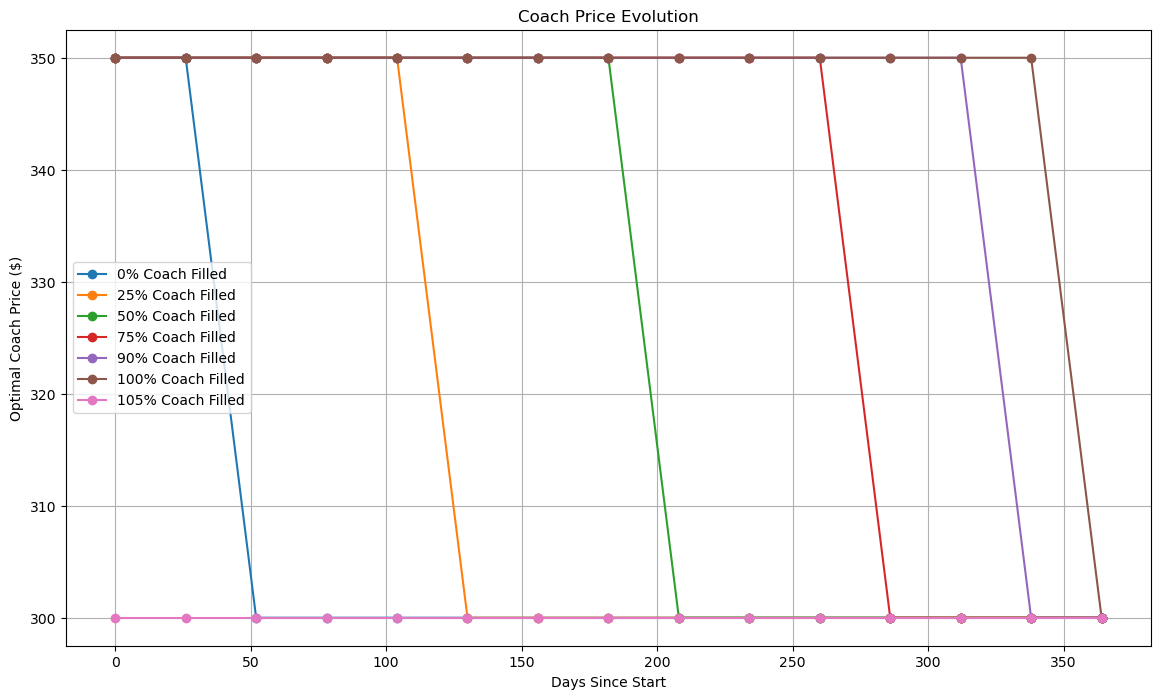

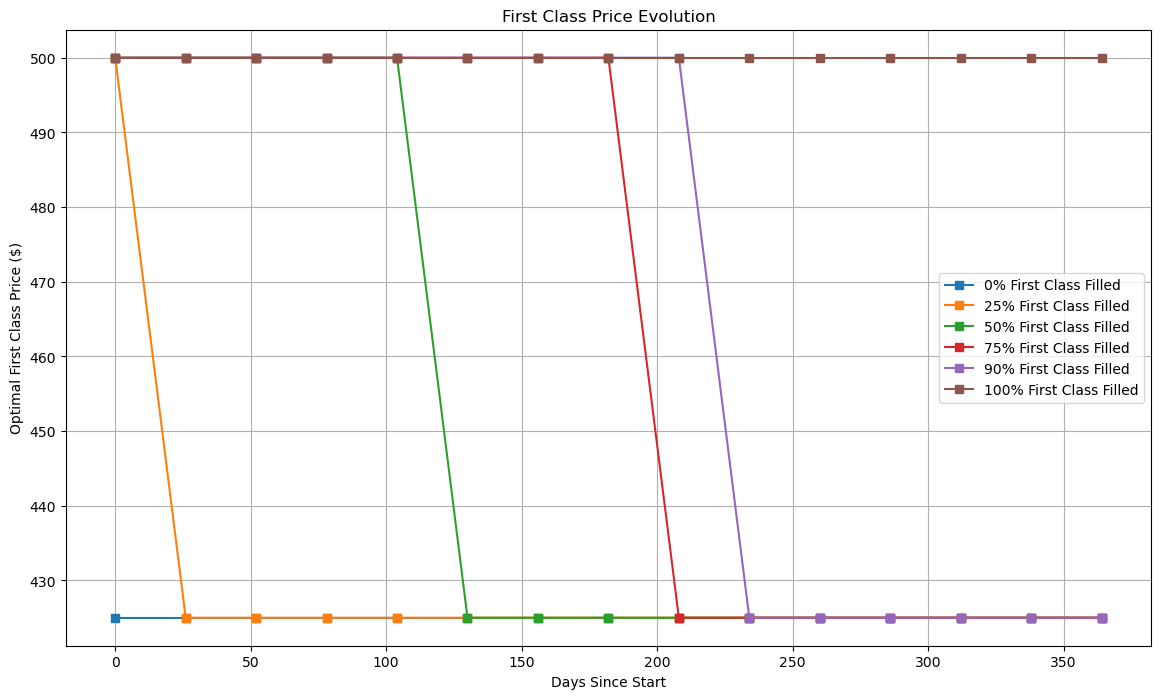

In [75]:
visualize_price_evolution(U_q1, params, 5, has_no_sale=False)

In [ ]:
results = compare_overbooking_levels(range(5, 16), params)

In [129]:
# print results
for ob, result in results.items():
    print(f"Overbooking Level: {ob}")
    print(f"Expected Profit: ${result['expected_profit']:.2f}")

Overbooking Level: 5
Expected Profit: $41886.16
Overbooking Level: 6
Expected Profit: $42011.22
Overbooking Level: 7
Expected Profit: $42085.54
Overbooking Level: 8
Expected Profit: $42122.17
Overbooking Level: 9
Expected Profit: $42134.62
Overbooking Level: 10
Expected Profit: $42132.90
Overbooking Level: 11
Expected Profit: $42123.67
Overbooking Level: 12
Expected Profit: $42111.03
Overbooking Level: 13
Expected Profit: $42097.42
Overbooking Level: 14
Expected Profit: $42084.11
Overbooking Level: 15
Expected Profit: $42071.74


# Question 3

In [77]:
def run_dp_with_no_sale_option(params):

    #unpack params
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    days = params['days_until_takeoff']
    discount = get_discount_factor(params['annual_discount_rate'])

    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']

    #fixed value of max coach tickets
    max_coach_tickets = 120

    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days + 1)) #stores values
    U = np.zeros_like(V, dtype=int) # stores actions

    # calculate terminal condition
    V = calculate_terminal_costs(
        V,
        max_coach_tickets=max_coach_tickets,
        first_class_seats=first_class_seats,
        coach_show_prob=params['coach_show_prob'],
        first_class_show_prob=params['first_class_show_prob'],
        coach_seats=coach_seats,
        cost_bump_to_fc=params['cost_bump_to_first_class'],
        cost_bump_off=params['cost_bump_off_plane']
    )

    for day in range(days - 1, -1, -1): #working backward
        for cs in range(max_coach_tickets + 1): # loop thorugh all possible coach seats sold
            for fs in range(first_class_seats + 1): #  loop through all possible first class seats sold

                if fs == first_class_seats: #if first class is full, limit our options to only the ones where first  class is high price  just to maintain consistency
                    allowed_actions = [0 * 2 + 1, 1 * 2 + 1, 2 * 2 + 1]  # no-sale, low, high — all with FC forced to high, this is a list of valid actions 
                else:
                    allowed_actions = range(6)  # initialize allowed actions to all possible actions combinations of coach and first class prices and no-sale 

                #every action is an integer between 0 and 5, and each action represents a combination of: (0,1,2) for coach, (0,1) for first class

                best_value = float('-inf') #best (highest) total expected profit we can achieve at the current state
                best_action = None #initialize best action to None

                for action in allowed_actions:
                    coach_option = action // 2  #0 (no sale), 1(low), 2(high) 
                    fc_option = action % 2     # 0 (low), 1(high)

                    # Coach logic
                    if coach_option == 0: #no sale coach
                        p_c = 0 # no sales
                        rev_c = 0 #no profit
                    else: # if we are selling coach tickets
                        price_c = coach_prices[coach_option - 1] #picking the actual dollar price (like $300 or $350) that corresponds to the coach_option chosen for that action.
                        if cs < max_coach_tickets: # if we still have capactity to sell another coach ticker 
                            p_c = coach_sale_prob_fc_sold_out[price_c] if fs == first_class_seats else coach_sale_prob[price_c] #assign the probability that a coach ticket actually gets sold at this price. if first class is sold, boosted probabiltiy for coach sales
                        else: #if we are out of coach tickets
                            p_c = 0 # no sales
                        rev_c = price_c * p_c #set reveune to the price of the coach ticket times the probability that it gets sold

                    # FC logic
                    if fs == first_class_seats: # if first class is full
                        price_fc = first_class_prices[1]  # Force to high
                        p_f = 0  # no sales
                    else: #if still space
                        price_fc = first_class_prices[fc_option] #set price
                        p_f = first_class_sale_prob[price_fc] #set prob
                    rev_f = price_fc * p_f if fs < first_class_seats else 0 #set revenue for fc

                    immediate_revenue = rev_c + rev_f # profit today

                    # Transition probabilities
                    prob_none = (1 - p_c) * (1 - p_f) # probability of no sales at all
                    prob_c_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0 #probability of only coach sales
                    prob_f_only = (1 - p_c) * p_f if fs < first_class_seats else 0 #prob first class ticket sold only
                    prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0 #prob that both are sold

                    future_value = 0 #intialize expected future value 

                    # add all the expected out comes of what could happen tomorrow given all the things that happened today
                    future_value += prob_none * V[cs, fs, day + 1] #expected future value if no tickets are sold today
                    if cs < max_coach_tickets: #if only a coach ticket sells
                        future_value += prob_c_only * V[cs + 1, fs, day + 1] #tomorroe we will have cs greater by 1 
                    if fs < first_class_seats:
                        future_value += prob_f_only * V[cs, fs + 1, day + 1]
                    if cs < max_coach_tickets and fs < first_class_seats:
                        future_value += prob_both * V[cs + 1, fs + 1, day + 1]

                    current_value = immediate_revenue + discount * future_value #value func

                    if current_value > best_value: #check if current value is better than what we have seen so far
                        best_value = current_value
                        best_action = action

                V[cs, fs, day] = best_value #store
                U[cs, fs, day] = best_action #store

    return V, U


In [79]:
V_q3, U_q3 = run_dp_with_no_sale_option(params)
print(f"Expected Profit: ${V_q3[0, 0, 0]:.2f}")

Expected Profit: $42139.89


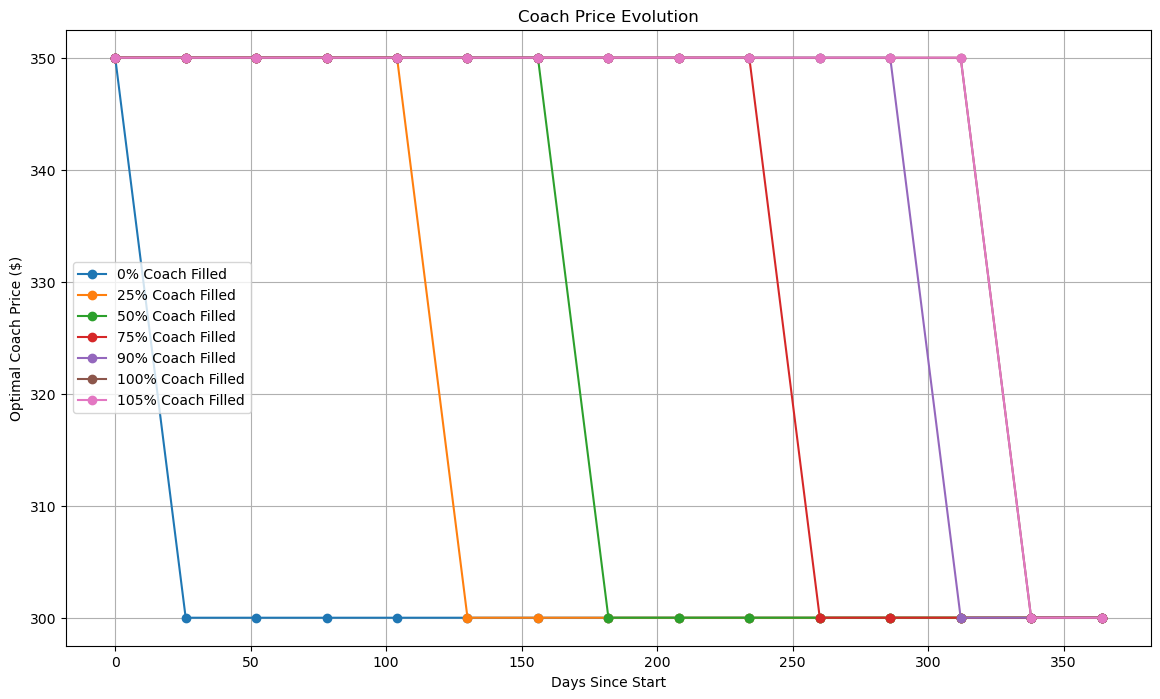

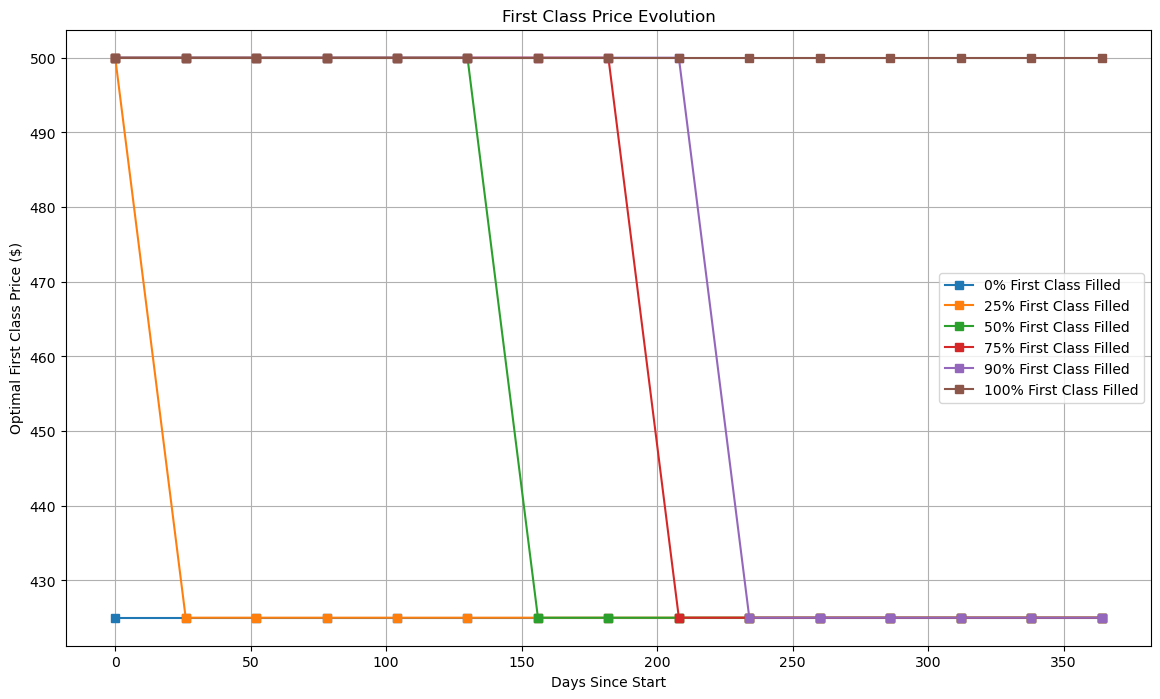

In [80]:
# Visualize price 
visualize_price_evolution(U_q3, params, 20, has_no_sale=True)

## Question 4

In [130]:
def run_dp_with_seasonality(ob_level, params):

    # unpack params
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']
    coach_show_prob = params['coach_show_prob']
    first_class_show_prob = params['first_class_show_prob']
    cost_bump_to_first_class = params['cost_bump_to_first_class']
    cost_bump_off_plane = params['cost_bump_off_plane']
    discount = get_discount_factor(params['annual_discount_rate'])

    max_coach_tickets = coach_seats + ob_level
    days = params['days_until_takeoff']

    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days + 1)) #store values
    U = np.zeros_like(V, dtype=int) #store actions

    # calculate terminal conditions
    V = calculate_terminal_costs(
        V,
        max_coach_tickets,
        first_class_seats,
        coach_show_prob,
        first_class_show_prob,
        coach_seats,
        cost_bump_to_first_class,
        cost_bump_off_plane
    )


    for day in range(days - 1, -1, -1): #working backward
        seasonality_factor = 0.75 + day / 730.0  # seasonality factor (increases over time)

        for coach_sold in range(max_coach_tickets + 1): #iterate over every possible combination of how many tickets were sold in coach
            for fc_sold in range(first_class_seats + 1): #iterate over every possible combination of how many tickets were sold in first class

                coach_available = coach_sold < max_coach_tickets #check if there are any coach seats available - boolean
                fc_available = fc_sold < first_class_seats #check if there are any first class seats available - boolean

               
                if not coach_available and not fc_available: #check if plane is completetly full
                    V[coach_sold, fc_sold, day] = discount * V[coach_sold, fc_sold, day + 1] #just discount the future value
                    continue

                # Set allowed actions depending on FC availability
                if fc_sold == first_class_seats: #if first class is sold out
                    allowed_actions = [1, 3, 5]  # only allow actions where fc is high
                else:
                    allowed_actions = range(6) #all actions allowed

                best_value = float('-inf') #initialize to  be negative infinity
                best_action = None #initialize best action to None

                for action in allowed_actions: #iterate through all possible actions
                    coach_option = action // 2  # 0 (no sale), 1 (low), 2 (high)
                    fc_option = action % 2     # 0 (low), 1 (high)

                    # Coach logic
                    if coach_option == 0: #if coach option is no sale
                        p_c = 0 #prob must be zero
                        rev_coach = 0 #revenue must be zero
                    else:
                        price_coach = coach_prices[coach_option - 1] # get the price of the coach ticket
                        base_c_prob = coach_sale_prob_fc_sold_out[price_coach] if (fc_sold == first_class_seats) else coach_sale_prob[price_coach] # get the base probability of selling a coach ticket
                        p_c = base_c_prob * seasonality_factor if coach_available else 0 # calculate the probability of selling a coach ticket, adjusted for seasonality
                        rev_coach = p_c * price_coach # calculate the revenue from selling a coach ticket

                    # First Class logic
                    if fc_sold == first_class_seats: # if first class is sold out
                        price_fc = first_class_prices[1] # Force to high
                        p_f = 0 #   no sales
                    else: #if first class is not sold out
                        price_fc = first_class_prices[fc_option] # get the price of the first class ticket
                        p_f = first_class_sale_prob[price_fc] * seasonality_factor if fc_available else 0 # calculate the probability of selling a first class ticket, adjusted for seasonality
                    rev_fc = p_f * price_fc # calculate the revenue from selling a first class ticket

                    immediate_revenue = rev_coach + rev_fc # calculate the immediate revenue from both coach and first class sales

                    # Transition probabilities
                    prob_none = (1 - p_c) * (1 - p_f) # probability of no sales
                    prob_coach_only = p_c * (1 - p_f) if coach_available else 0 # probability of only coach selling
                    prob_fc_only = (1 - p_c) * p_f if fc_available else 0 # probability of only first class selling
                    prob_both = p_c * p_f if (coach_available and fc_available) else 0 # probability of both selling

                    # Expected future value for all 6 actions 
                    expected_future_value = (
                        prob_none * V[coach_sold, fc_sold, day + 1]
                        + (prob_coach_only * V[coach_sold + 1, fc_sold, day + 1] if coach_available else 0)
                        + (prob_fc_only * V[coach_sold, fc_sold + 1, day + 1] if fc_available else 0)
                        + (prob_both * V[coach_sold + 1, fc_sold + 1, day + 1] if (coach_available and fc_available) else 0)
                    )

                    current_value = immediate_revenue + discount * expected_future_value # calculate the current value by combining immediate revenue with discounted expected future value

                    if current_value > best_value: #only update if current value is better than what we have seen so far
                        best_value = current_value
                        best_action = action

                V[coach_sold, fc_sold, day] = best_value #store the best value
                U[coach_sold, fc_sold, day] = best_action #store the best action

    return V, U


In [82]:
V_q4, U_q4 = run_dp_with_seasonality(ob_level=20, params=params)

In [64]:
print(f"Expected Profit: ${V_q4[0, 0, 0]:.2f}")

Expected Profit: $41830.46


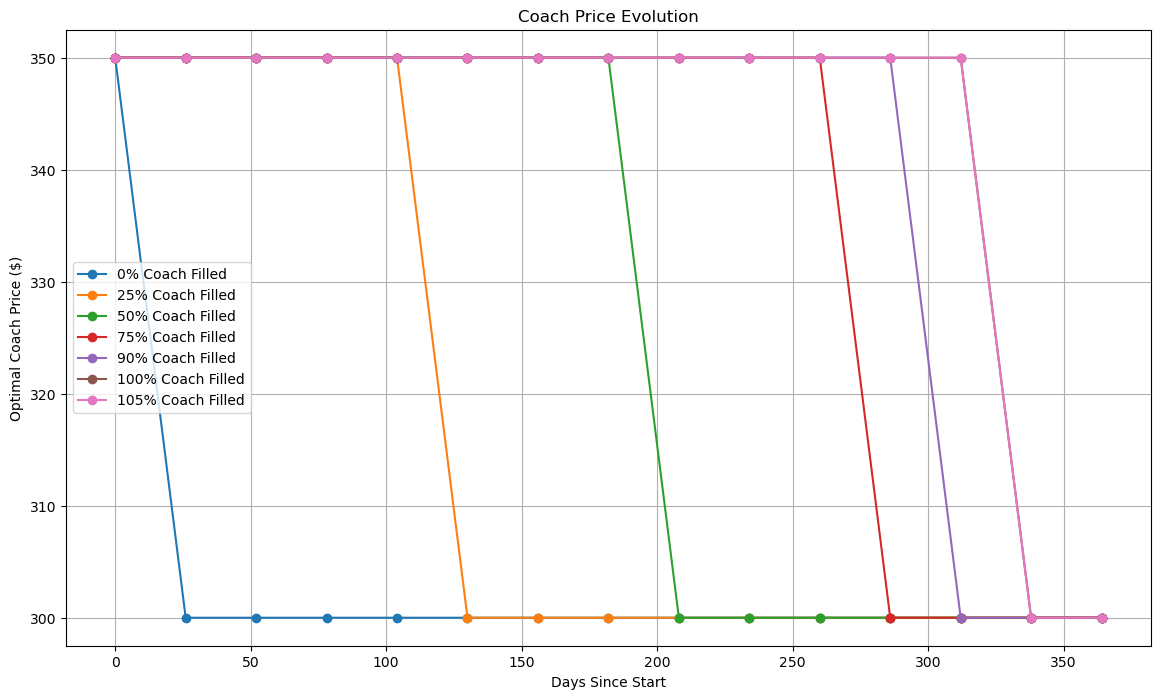

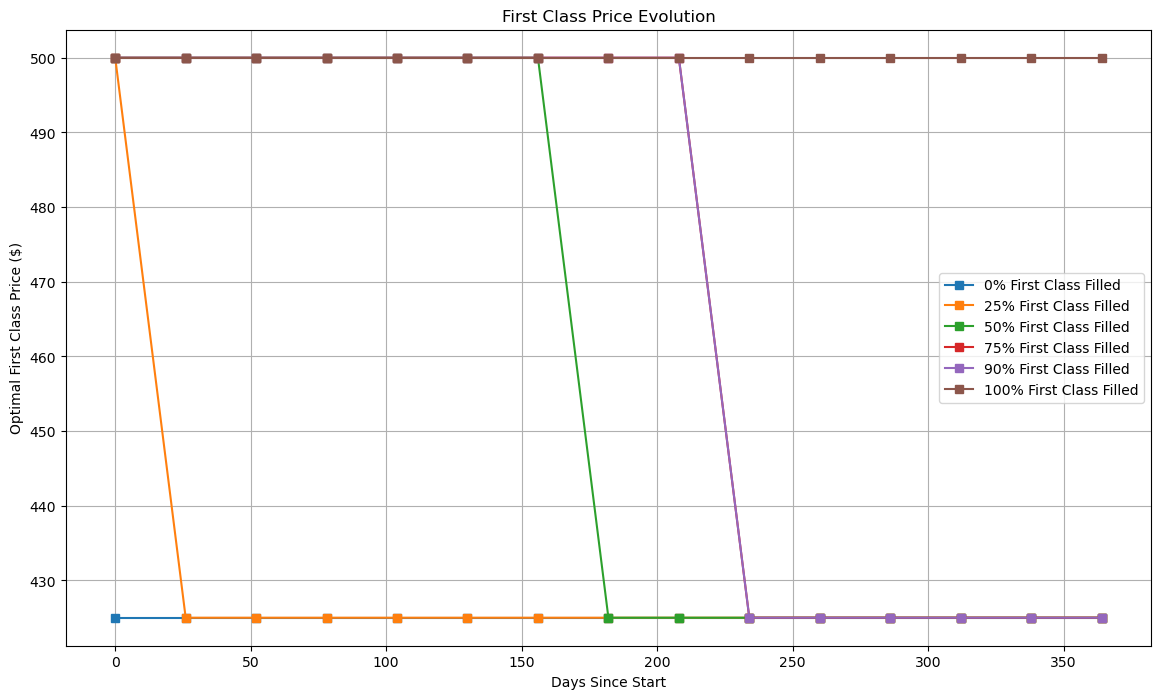

In [83]:
# # Visualize the price evolution
visualize_price_evolution(U_q4, params, ob_level=20, has_no_sale=True)  # seasonality affects probabilities but not function arguments

# Question 5 - Simulations

In [108]:
def simulate_policy(policy, params, ob_level=0, num_simulations=10000, policy_type="DP"):

    # unpack params
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    days_until_takeoff = params['days_until_takeoff']
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']
    coach_show_prob = params['coach_show_prob']
    first_class_show_prob = params['first_class_show_prob']
    cost_bump_to_first_class = params['cost_bump_to_first_class']
    cost_bump_off_plane = params['cost_bump_off_plane']
    daily_discount_factor = get_discount_factor(params['annual_discount_rate'])
    max_coach_tickets = coach_seats + ob_level

    # store simulation results
    discounted_profits = []
    coach_overbook_flags = []
    kicked_off_flags = []
    overbooking_costs = []
    coach_tickets_sold_all = []
    fc_tickets_sold_all = []
    
    np.random.seed(42)
    for sim in range(num_simulations):
        cs = 0  # coach tickets sold
        fs = 0  # first class tickets sold
        revenue = 0.0

        for t in range(days_until_takeoff):
            factor = 0.75 + t/730.0  # seasonality factor adjustment

            if policy_type == "DP":
                action = policy[cs, fs, t]
                coach_option = action // 2  # 0: no sale, 1: low price, 2: high price
                fc_option = action % 2      # 0: low price, 1: high price
            else:
                coach_option = 1  # always low price
                fc_option = 0

            # Coach sale
            if coach_option == 0: # no sale
                p_c = 0
            else: # sale
                price_coach = coach_prices[coach_option - 1]
                if cs < max_coach_tickets:
                    base_p = coach_sale_prob_fc_sold_out[price_coach] if fs == first_class_seats else coach_sale_prob[price_coach]
                else:
                    base_p = 0
                p_c = base_p * factor

            if cs < max_coach_tickets and np.random.rand() < p_c: # if there are still coach seats available
                cs += 1
                revenue += price_coach * (daily_discount_factor ** t)

            # First class sale
            if fs < first_class_seats: # if there are still first class seats available
                price_fc = first_class_prices[fc_option]
                p_f = first_class_sale_prob[price_fc] * factor
                if np.random.rand() < p_f:
                    fs += 1
                    revenue += price_fc * (daily_discount_factor ** t)

        # Departure day - Show-ups
        coach_show = np.random.binomial(cs, coach_show_prob) # simulate the number of coach passengers who show up
        fc_show = np.random.binomial(fs, first_class_show_prob) # simulate the number of first class passengers who show up

        if coach_show > coach_seats: # if more passengers show up than there are coach seats available - bumped logic (similar to terminal condition)
            bumped = coach_show - coach_seats # calculate number of passengers to be bumped - people who cant be seated in coach
            available_fc = max(0, first_class_seats - fc_show) # calculate number of first class seats available - bumped will be put there first
            bumped_to_fc = min(bumped, available_fc) # the number of bumped passengers who can be accommodated in first class
            bumped_off = bumped - bumped_to_fc # calculate number of passengers to be bumped off plane
            flight_cost = (bumped_to_fc * cost_bump_to_first_class + bumped_off * cost_bump_off_plane) * (daily_discount_factor ** days_until_takeoff)
        else:
            flight_cost = 0

        profit = revenue - flight_cost # calculate profit
        discounted_profits.append(profit) 
        coach_overbook_flags.append(coach_show > coach_seats)
        kicked_off_flags.append(bumped_off > 0 if coach_show > coach_seats else False)
        overbooking_costs.append(flight_cost)
        coach_tickets_sold_all.append(cs)
        fc_tickets_sold_all.append(fs)

    # Collect stats
    stats = {
        'avg_profit': np.mean(discounted_profits),
        'profit_volatility': np.std(discounted_profits),
        'pct_overbooked': 100 * np.mean(coach_overbook_flags),
        'pct_kicked_off': 100 * np.mean(kicked_off_flags),
        'avg_overbooking_cost': np.mean(overbooking_costs),
        'avg_coach_sold': np.mean(coach_tickets_sold_all),
        'avg_fc_sold': np.mean(fc_tickets_sold_all),
        'discounted_profits': discounted_profits,
        'coach_tickets_sold_all': coach_tickets_sold_all,
        'fc_tickets_sold_all': fc_tickets_sold_all,
        'overbooking_costs_all': overbooking_costs
    }

    return stats


## Visualizations for Simulation

In [111]:
def plot_profit_boxplot(sim_dp, sim_naive):
    plt.figure(figsize=(10,6))
    data = [sim_dp['discounted_profits'], sim_naive['discounted_profits']]
    sns.boxplot(data=data)
    plt.xticks([0,1], ['DP Policy', 'Naive Policy'])
    plt.ylabel('Discounted Profit ($)')
    plt.title('Distribution of Discounted Profits')
    plt.show()

def plot_profit_histogram(sim_dp, sim_naive):
    plt.figure(figsize=(10,6))
    sns.histplot(sim_dp['discounted_profits'], bins=50, kde=True, color='blue', label='DP Policy', stat='density')
    sns.histplot(sim_naive['discounted_profits'], bins=50, kde=True, color='orange', label='Naive Policy', stat='density')
    plt.xlabel('Discounted Profit ($)')
    plt.ylabel('Density')
    plt.title('Histogram of Discounted Profits')
    plt.legend()
    plt.show()

def plot_coach_tickets_histogram(sim_dp):
    plt.figure(figsize=(10,6))
    sns.histplot(sim_dp['coach_tickets_sold_all'], bins=12, kde=True, color='blue', label='DP Policy', stat='count')
    plt.xlabel('Coach Tickets Sold')
    plt.ylabel('Frequency')
    plt.title('Histogram of Coach Tickets Sold')
    plt.legend()
    plt.show()

def plot_overbooking_bar(sim_dp, sim_naive):
    labels = ['Coach Overbooked (%)', 'Passengers Kicked Off (%)']
    dp_values = [sim_dp['pct_overbooked'], sim_dp['pct_kicked_off']]
    naive_values = [sim_naive['pct_overbooked'], sim_naive['pct_kicked_off']]
    
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8,6))
    plt.bar(x - width/2, dp_values, width, label='DP Policy')
    plt.bar(x + width/2, naive_values, width, label='Naive Policy')
    plt.xticks(x, labels)
    plt.ylabel('Percentage (%)')
    plt.title('Frequency of Coach Overbooking and Passenger Kick-Offs')
    plt.legend()
    plt.show()


### Simulating Question 1 - Overbooking by 5

In [134]:

num_simulations = 100000
sim_dp = simulate_policy(U_q1, params, ob_level=5, num_simulations=num_simulations, policy_type="DP")
sim_naive = simulate_policy(None, params, ob_level=5, num_simulations=num_simulations, policy_type="naive")


In [135]:
#print stats
print(f"DP Expected Profit: ${sim_dp['avg_profit']:.2f}")
print(f"DP Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"DP Overbooked: {sim_dp['pct_overbooked']:.2f}%")
print(f"DP Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"DP Avg Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"DP Avg Coach Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"DP Avg First Class Sold: {sim_dp['avg_fc_sold']:.2f}")

print(f"Naive Expected Profit: ${sim_naive['avg_profit']:.2f}")
print(f"Naive Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"Naive Overbooked: {sim_naive['pct_overbooked']:.2f}%")  
print(f"Naive Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"Naive Avg Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"Naive Avg Coach Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"Naive Avg First Class Sold: {sim_naive['avg_fc_sold']:.2f}")

DP Expected Profit: $38148.03
DP Profit Volatility: $527.83
DP Overbooked: 39.27%
DP Kicked Off: 28.54%
DP Avg Overbooking Cost: $194.28
DP Avg Coach Sold: 105.00
DP Avg First Class Sold: 19.87
Naive Expected Profit: $37848.68
Naive Profit Volatility: $411.02
Naive Overbooked: 39.29%
Naive Kicked Off: 29.47%
Naive Avg Overbooking Cost: $199.52
Naive Avg Coach Sold: 105.00
Naive Avg First Class Sold: 19.94


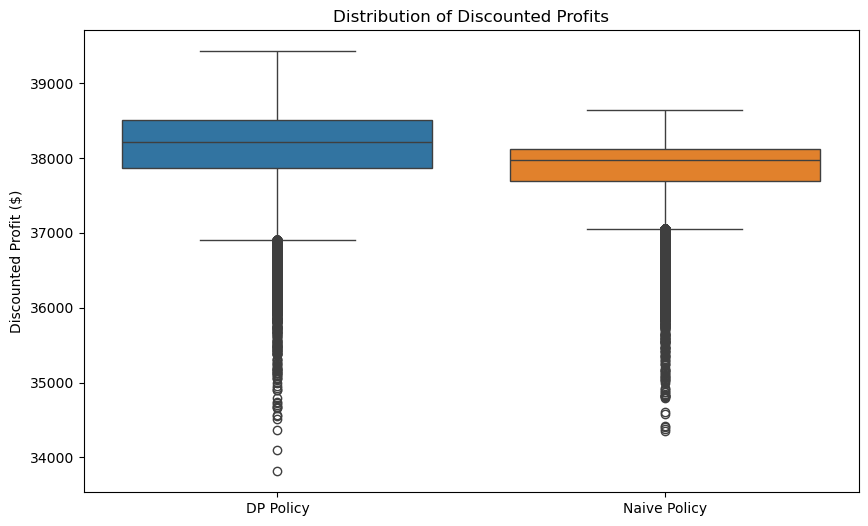

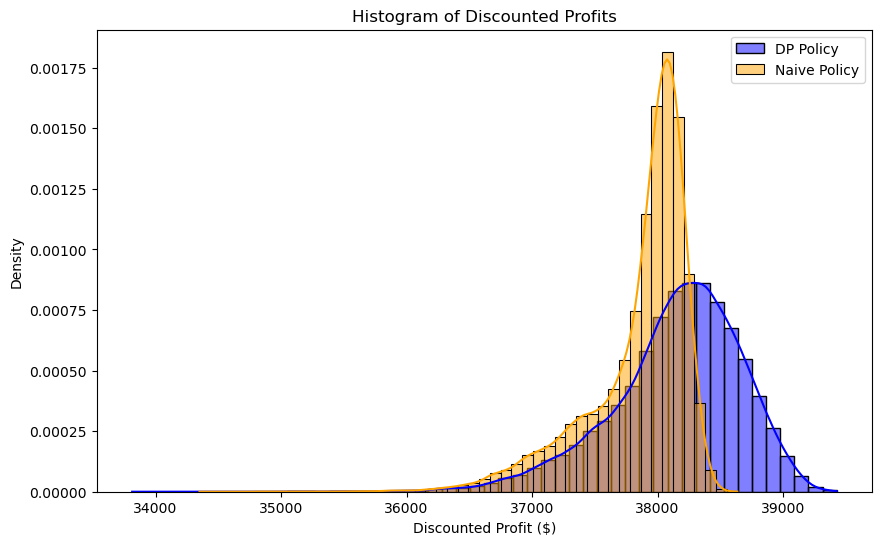

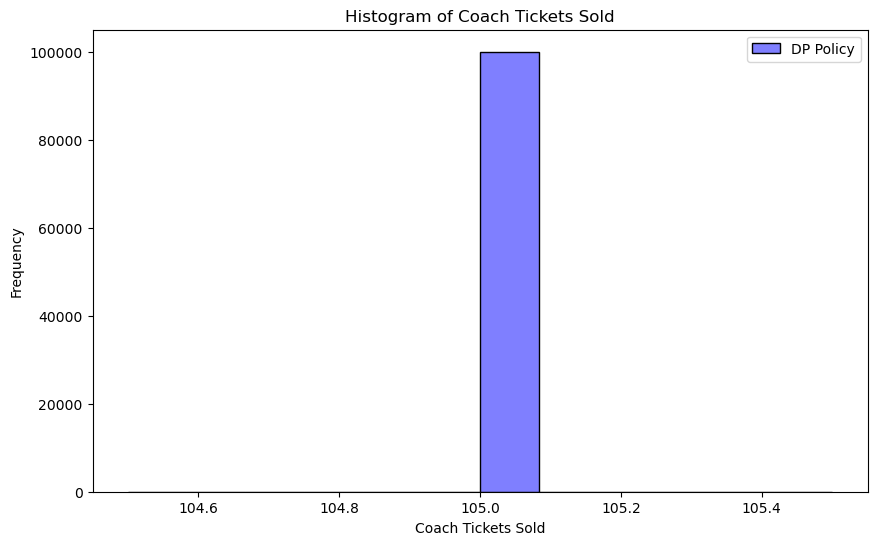

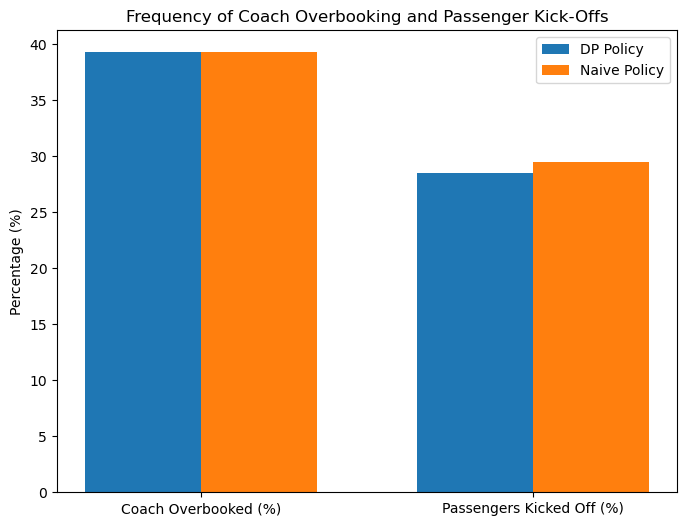

In [136]:
plot_profit_boxplot(sim_dp, sim_naive)
plot_profit_histogram(sim_dp, sim_naive)
plot_coach_tickets_histogram(sim_dp)
plot_overbooking_bar(sim_dp, sim_naive)

### Simulating Question 2 - Overbooking by 9

In [149]:
U_q2_9 = results[9]['policy']

In [150]:

num_simulations = 100000
sim_dp = simulate_policy(U_q2_9, params, ob_level=9, num_simulations=num_simulations, policy_type="DP")
sim_naive = simulate_policy(None, params, ob_level=9, num_simulations=num_simulations, policy_type="naive")


In [151]:
#print stats
print(f"DP Expected Profit: ${sim_dp['avg_profit']:.2f}")
print(f"DP Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"DP Overbooked: {sim_dp['pct_overbooked']:.2f}%")
print(f"DP Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"DP Avg Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"DP Avg Coach Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"DP Avg First Class Sold: {sim_dp['avg_fc_sold']:.2f}")

print(f"Naive Expected Profit: ${sim_naive['avg_profit']:.2f}")
print(f"Naive Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"Naive Overbooked: {sim_naive['pct_overbooked']:.2f}%")  
print(f"Naive Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"Naive Avg Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"Naive Avg Coach Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"Naive Avg First Class Sold: {sim_naive['avg_fc_sold']:.2f}")

DP Expected Profit: $38381.68
DP Profit Volatility: $833.59
DP Overbooked: 90.26%
DP Kicked Off: 80.85%
DP Avg Overbooking Cost: $1051.71
DP Avg Coach Sold: 109.00
DP Avg First Class Sold: 19.67
Naive Expected Profit: $38026.54
Naive Profit Volatility: $767.30
Naive Overbooked: 90.43%
Naive Kicked Off: 83.98%
Naive Avg Overbooking Cost: $1121.35
Naive Avg Coach Sold: 109.00
Naive Avg First Class Sold: 19.94


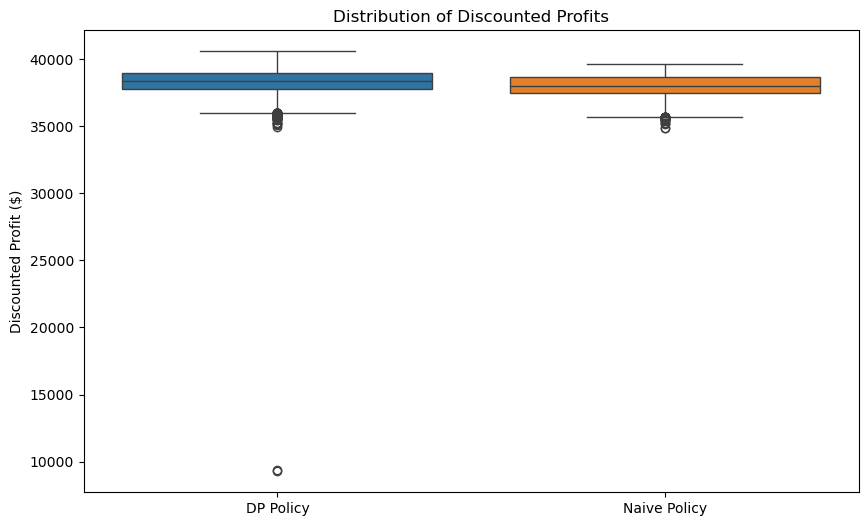

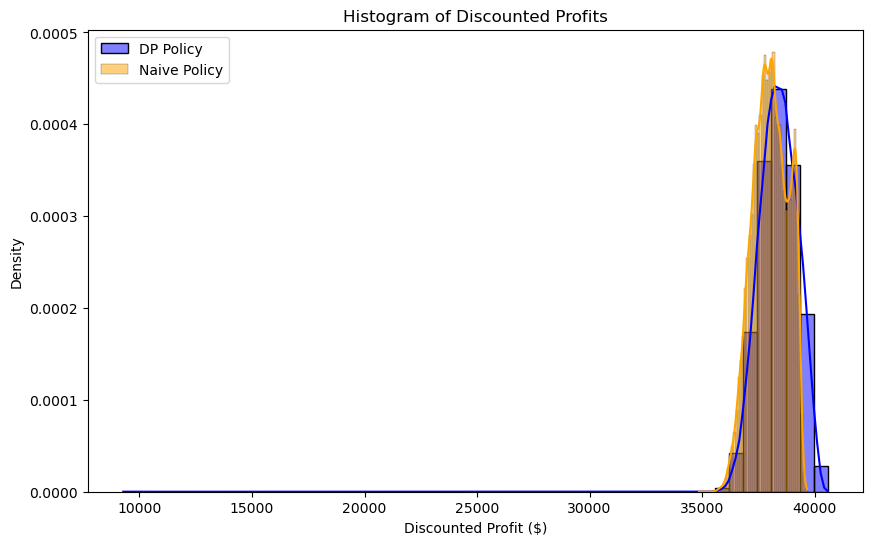

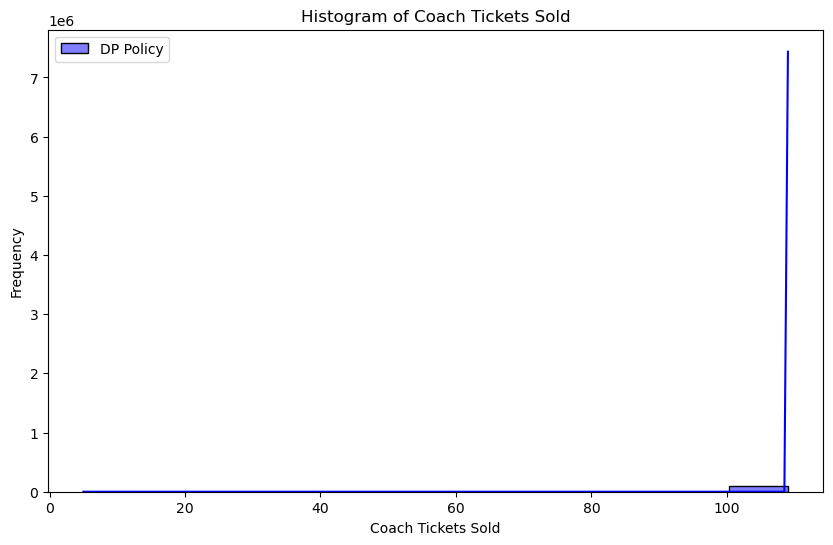

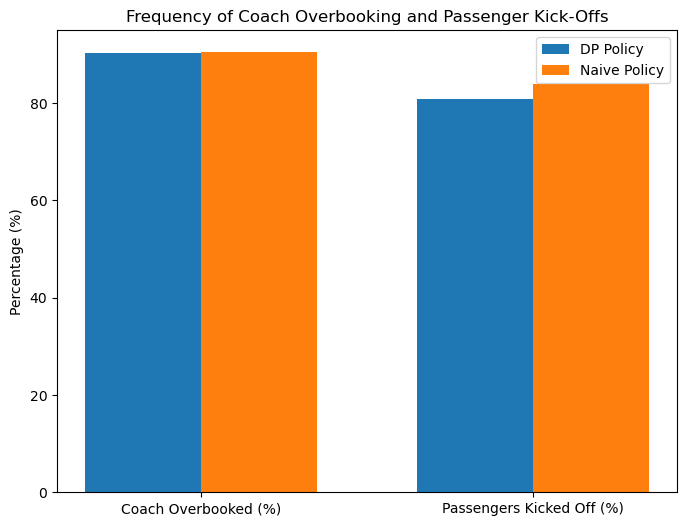

In [152]:
plot_profit_boxplot(sim_dp, sim_naive)
plot_profit_histogram(sim_dp, sim_naive)
plot_coach_tickets_histogram(sim_dp)
plot_overbooking_bar(sim_dp, sim_naive)

### Simulating Question 3 - No Sale Option

In [142]:

num_simulations = 100000
sim_dp = simulate_policy(U_q3, params, ob_level=20, num_simulations=num_simulations, policy_type="DP")
sim_naive = simulate_policy(None, params, ob_level=20, num_simulations=num_simulations, policy_type="naive")


In [143]:
#print stats
print(f"DP Expected Profit: ${sim_dp['avg_profit']:.2f}")
print(f"DP Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"DP Overbooked: {sim_dp['pct_overbooked']:.2f}%")
print(f"DP Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"DP Avg Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"DP Avg Coach Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"DP Avg First Class Sold: {sim_dp['avg_fc_sold']:.2f}")

print(f"Naive Expected Profit: ${sim_naive['avg_profit']:.2f}")
print(f"Naive Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"Naive Overbooked: {sim_naive['pct_overbooked']:.2f}%")  
print(f"Naive Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"Naive Avg Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"Naive Avg Coach Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"Naive Avg First Class Sold: {sim_naive['avg_fc_sold']:.2f}")

DP Expected Profit: $41759.37
DP Profit Volatility: $937.98
DP Overbooked: 87.43%
DP Kicked Off: 79.26%
DP Avg Overbooking Cost: $1020.36
DP Avg Coach Sold: 108.78
DP Avg First Class Sold: 19.75
Naive Expected Profit: $37346.34
Naive Profit Volatility: $905.69
Naive Overbooked: 100.00%
Naive Kicked Off: 100.00%
Naive Avg Overbooking Cost: $4809.66
Naive Avg Coach Sold: 120.00
Naive Avg First Class Sold: 19.94


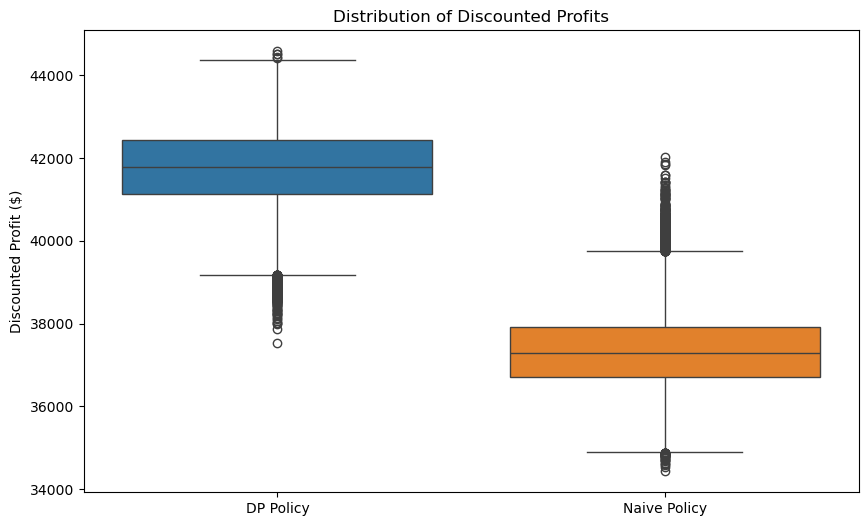

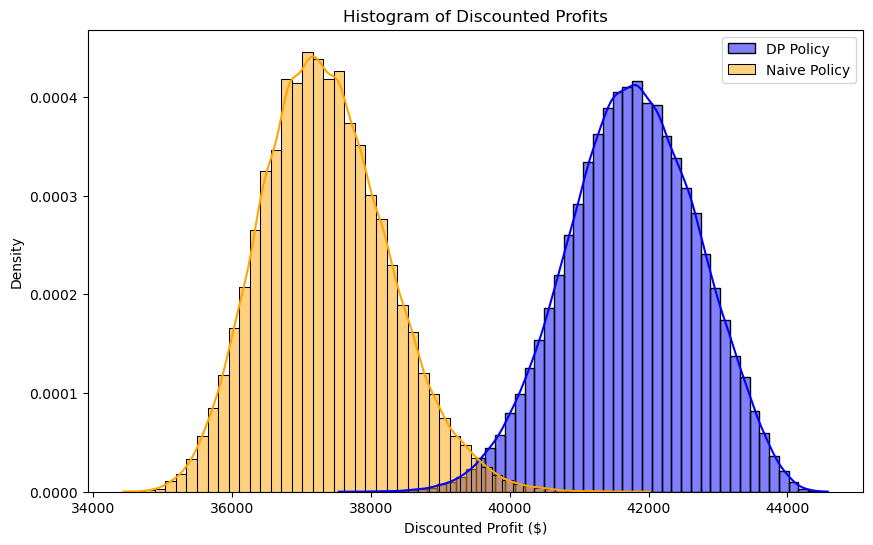

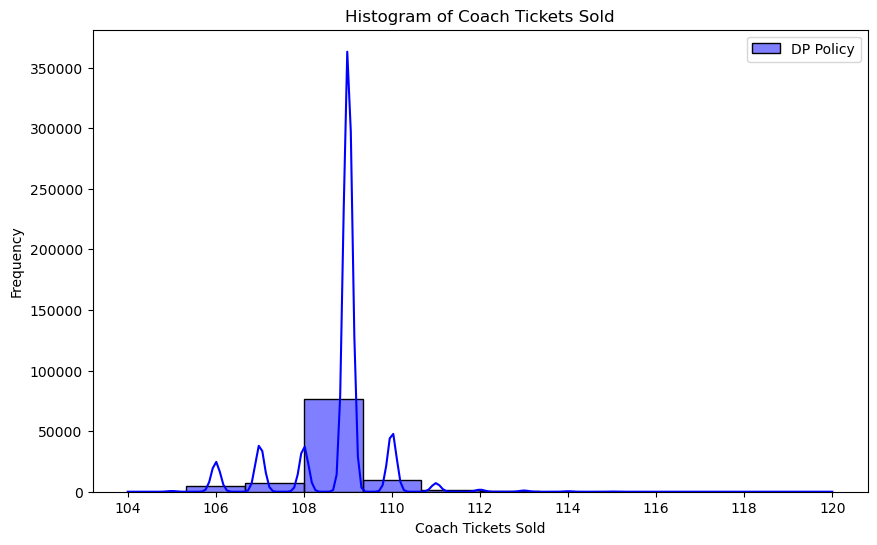

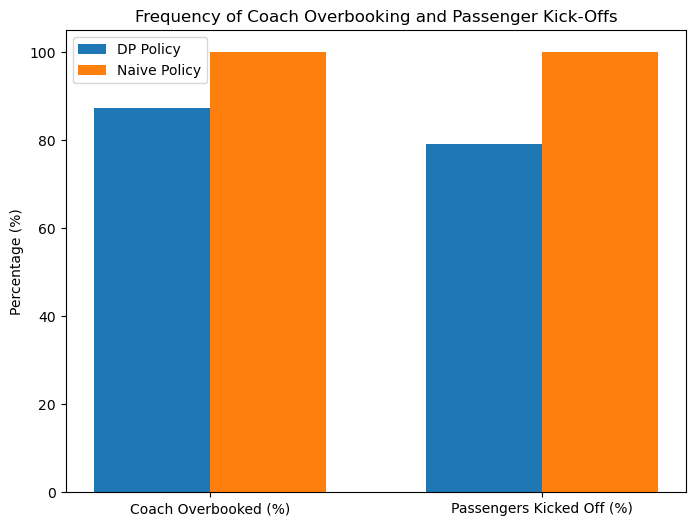

In [144]:
plot_profit_boxplot(sim_dp, sim_naive)
plot_profit_histogram(sim_dp, sim_naive)
plot_coach_tickets_histogram(sim_dp)
plot_overbooking_bar(sim_dp, sim_naive)

### Simulating Question 4 - Seasonality

In [138]:

num_simulations = 100000
sim_dp = simulate_policy(U_q4, params, ob_level=20, num_simulations=num_simulations, policy_type="DP")
sim_naive = simulate_policy(None, params, ob_level = 20, num_simulations=num_simulations, policy_type="naive")


In [140]:
#print stats
print(f"DP Expected Profit: ${sim_dp['avg_profit']:.2f}")
print(f"DP Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"DP Overbooked: {sim_dp['pct_overbooked']:.2f}%")
print(f"DP Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"DP Avg Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"DP Avg Coach Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"DP Avg First Class Sold: {sim_dp['avg_fc_sold']:.2f}")

print(f"Naive Expected Profit: ${sim_naive['avg_profit']:.2f}")
print(f"Naive Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"Naive Overbooked: {sim_naive['pct_overbooked']:.2f}%")  
print(f"Naive Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"Naive Avg Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"Naive Avg Coach Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"Naive Avg First Class Sold: {sim_naive['avg_fc_sold']:.2f}")

DP Expected Profit: $41833.27
DP Profit Volatility: $932.13
DP Overbooked: 82.34%
DP Kicked Off: 70.99%
DP Avg Overbooking Cost: $852.63
DP Avg Coach Sold: 108.34
DP Avg First Class Sold: 19.55
Naive Expected Profit: $37346.34
Naive Profit Volatility: $905.69
Naive Overbooked: 100.00%
Naive Kicked Off: 100.00%
Naive Avg Overbooking Cost: $4809.66
Naive Avg Coach Sold: 120.00
Naive Avg First Class Sold: 19.94


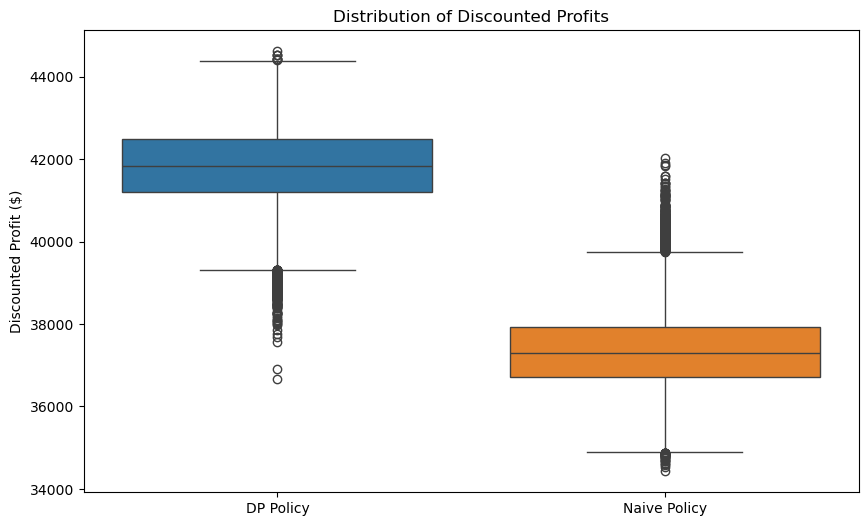

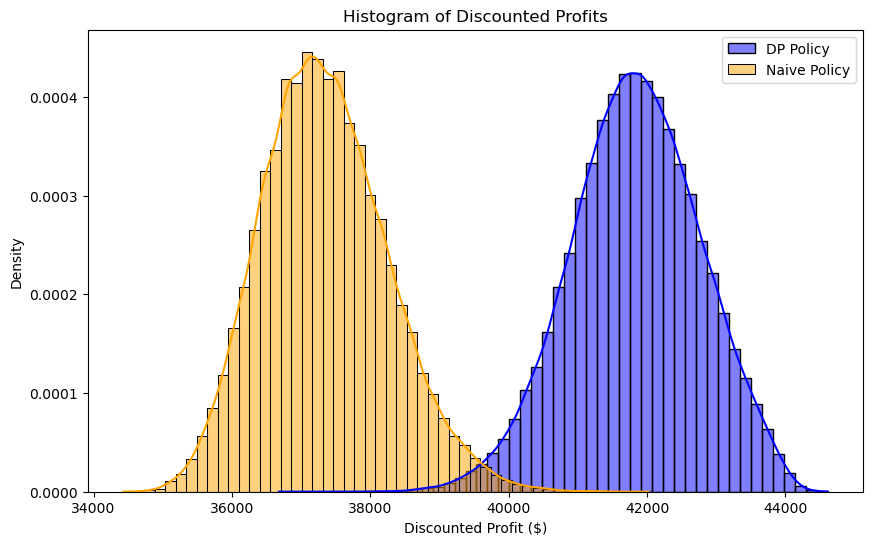

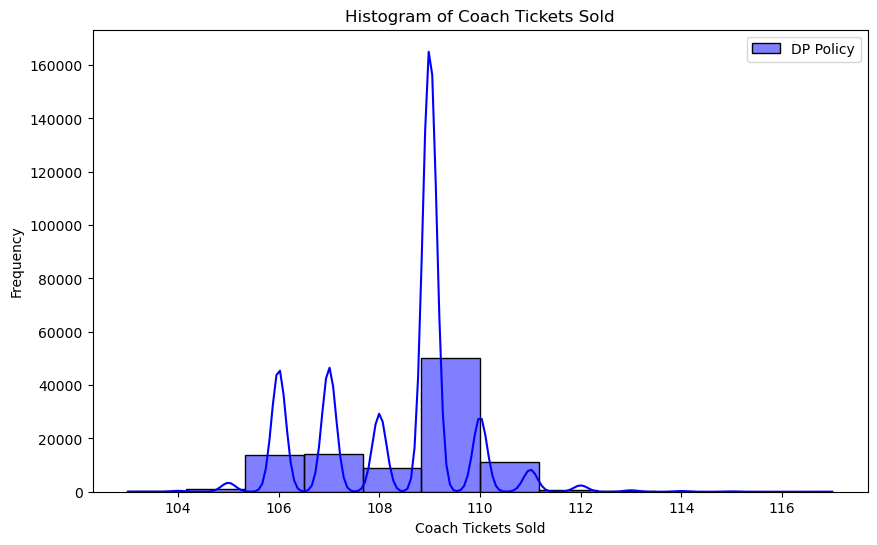

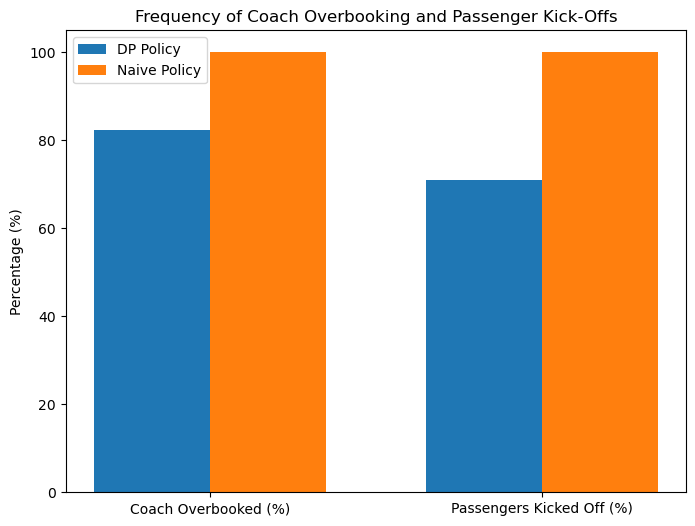

In [141]:
plot_profit_boxplot(sim_dp, sim_naive)
plot_profit_histogram(sim_dp, sim_naive)
plot_coach_tickets_histogram(sim_dp)
plot_overbooking_bar(sim_dp, sim_naive)
